In [1]:
!pip install jaxlib --upgrade

     |████████████████████████████████| 34.3MB 119kB/s 
  Found existing installation: jaxlib 0.1.57+cuda101
    Uninstalling jaxlib-0.1.57+cuda101:
      Successfully uninstalled jaxlib-0.1.57+cuda101


In [2]:
# tensorflow_federated_nightly also bring in tf_nightly, which
# can causes a duplicate tensorboard install, leading to errors.
!pip uninstall --yes tensorboard tb-nightly

!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio
!pip install --quiet tb-nightly  # or tensorboard, but not both

import nest_asyncio
nest_asyncio.apply()

Uninstalling tensorboard-2.4.1:
  Successfully uninstalled tensorboard-2.4.1
     |████████████████████████████████| 583kB 7.3MB/s 
     |████████████████████████████████| 174kB 14.4MB/s 
     |████████████████████████████████| 552kB 13.2MB/s 
     |████████████████████████████████| 716kB 32.0MB/s 
     |████████████████████████████████| 403.1MB 38kB/s 
     |████████████████████████████████| 153kB 50.4MB/s 
     |████████████████████████████████| 471kB 37.2MB/s 
     |████████████████████████████████| 12.3MB 43.1MB/s 
ERROR: tensorflow 2.4.1 requires tensorboard~=2.4, which is not installed.
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20210128 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20210128 has requirement h5py~=3.1.0, bu

In [3]:

%load_ext tensorboard

In [4]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210128). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

In [5]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 1s 0us/step


In [6]:
print(len(emnist_train.client_ids))

emnist_train.element_type_structure

3383


OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [7]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

# for printing all labels
#for i in example_dataset:
#  print(i['label'].numpy())

5

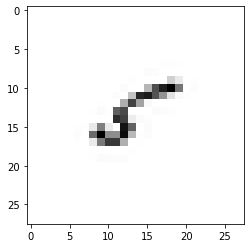

In [8]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

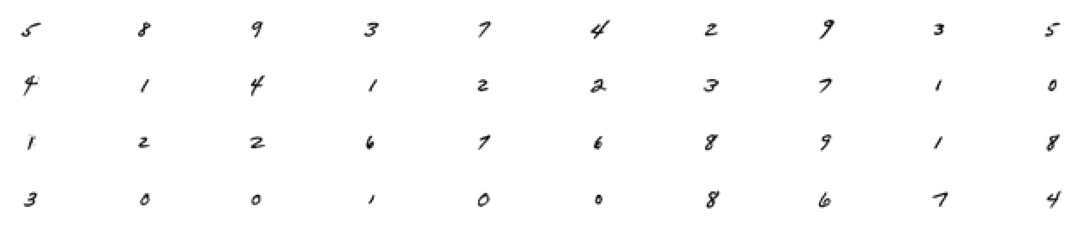

In [9]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

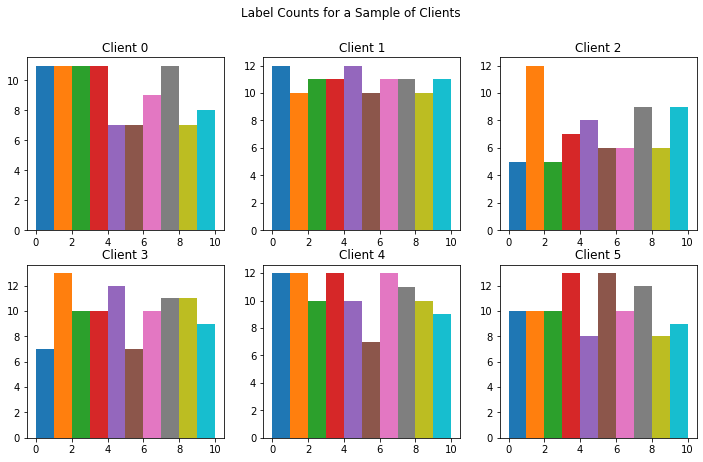

In [10]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Processing

In [11]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [12]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

#code to access each batch
#or i in preprocessed_example_dataset:
#  print(i['y'])
#  break

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[9],
                     [8],
                     [5],
                     [8],
                     [9],
                     [6],
                     [0],
                     [6],
                     [3],
                     [2],
                     [0],
                     [7],
                     [2],
                     [6],
                     [1],
                     [7],
                     [8],
                     [5],
                     [4],
                     [3]], dtype=int32))])

In [26]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [27]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>
